In [19]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule as Mod
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn

from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import (
    Compose,
    DoubleToFloat,
    ObservationNorm,
    StepCounter,
    TransformedEnv,
)
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, ExplorationType, set_exploration_type
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

device = torch.device("cpu")
num_cells = 256
lr = 3e-4
max_grad_norm = 1.0

# collection Params
frames_per_batch = 1000
# For complete training, bring the number of frames up to 1M
total_frames = 10_000

# PPO params
sub_batch_size = 64  # cardinality of the sub-samples gathered from the current dat in the inner loop
num_epochs = 10
clip_epsilon = (0.2)  # PPO clip value for loss
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

# Define Env
base_env = GymEnv("InvertedDoublePendulum-v4", device=device)
env = TransformedEnv(
    base_env,
    Compose(
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(),
        StepCounter()
    )
)
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)
print("normalization constant shape:", env.transform[0].loc)
check_env_specs(env)
print("input_spec:", env.input_spec)

# Policy
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    # The 2 * action_sped is because for each action we produce 2 scalars (loc, scale)
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

policy_module = Mod(actor_net, in_keys=["observation"], out_keys=["loc", "scale"])

policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.low,
        "max": env.action_spec.space.high,
    },
    return_log_prob=True
    # we'll need the log-prob for the numerator of the importance weights
)

# Value net
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

# Collectors
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

# Replay Buffers
"""TorchRL’s replay buffers are built using a common container ReplayBuffer which takes as argument the components of the buffer: a storage, a writer, a sampler and possibly some transforms. Only the storage (which indicates the replay buffer capacity) is mandatory. We also specify a sampler without repetition to avoid sampling multiple times the same item in one epoch. Using a replay buffer for PPO is not mandatory and we could simply sample the sub-batches from the collected batch, but using these classes make it easy for us to build the inner training loop in a reproducible way."""
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(max_size=frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)

# Advantage and Loss
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor_network=policy_module,
    critic_network=value_module,
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default, but we set this for completeness
    critic_coef=1.0,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

# Training Loop
logs = defaultdict(list)
pbar = tqdm(total=total_frames)
eval_str = ""

# We iterate over the collector until it reaches the total number of frames it was
# designed to collect:
for i, tensordict_data in enumerate(collector):
    # we now have a batch of data to work with. Let's learn something from it.
    for _ in range(num_epochs):
        # We'll need an "advantage" signal to make PPO work.
        # We re-compute it at each epoch as its value depends on the value
        # network which is updated in the inner loop.
        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            # Optimization: backward, grad clipping and optimization step
            loss_value.backward()
            # this is not strictly mandatory but it's good practice to keep
            # your gradient norm bounded
            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel())
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        # We evaluate the policy once every 10 batches of data.
        # Evaluation is rather simple: execute the policy without exploration
        # (take the expected value of the action distribution) for a given
        # number of steps (1000, which is our ``env`` horizon).
        # The ``rollout`` method of the ``env`` can take a policy as argument:
        # it will then execute this policy at each step.
        with set_exploration_type(ExplorationType.MEAN), torch.no_grad():
            # execute a rollout with the trained policy
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))

    # We're also using a learning rate scheduler. Like the gradient clipping,
    # this is a nice-to-have but nothing necessary for PPO to work.
    scheduler.step()
print('finished')

/home/kostiskak/anaconda3/envs/rl_env/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_envs to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_envs` for environment variables or `env.get_wrapper_attr('num_envs')` that will search the reminding wrappers.
  logger.warn(
/home/kostiskak/anaconda3/envs/rl_env/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.reward_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.reward_space` for environment variables or `env.get_wrapper_attr('reward_space')` that will search the reminding wrappers.
  logger.warn(
2024-03-28 02:34:24,962 [torchrl][INFO] check_env_specs succeeded!
/home/kostiskak/anaconda3/envs/rl_env/lib/python3.11/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy developmen

normalization constant shape: tensor([ -0.1633,   0.1661,  -0.1443, -12.5019,  -6.6290,  -0.1793,   0.1939,
         -0.1768,  -0.0000,  -0.0000,  -0.0000], dtype=torch.float64)
input_spec: CompositeSpec(
    full_state_spec: CompositeSpec(
        step_count: BoundedTensorSpec(
            shape=torch.Size([1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True),
                high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.int64, contiguous=True)),
            device=cpu,
            dtype=torch.int64,
            domain=continuous), device=cpu, shape=torch.Size([])),
    full_action_spec: CompositeSpec(
        action: BoundedTensorSpec(
            shape=torch.Size([1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, conti


eval cumulative reward:  73.2974 (init:  73.2974), eval step-count: 7, average reward= 9.2427 (init= 9.0948), step count (max): 45, lr policy:  0.0000: 100%|██████████| 10000/10000 [06:38<00:00, 25.08it/s] 

 10%|█         | 1000/10000 [00:02<00:24, 365.38it/s]
eval cumulative reward:  101.7022 (init:  101.7022), eval step-count: 10, average reward= 9.0874 (init= 9.0874), step count (max): 12, lr policy:  0.0003:  10%|█         | 1000/10000 [00:02<00:24, 365.38it/s]
eval cumulative reward:  101.7022 (init:  101.7022), eval step-count: 10, average reward= 9.0874 (init= 9.0874), step count (max): 12, lr policy:  0.0003:  20%|██        | 2000/10000 [00:05<00:20, 392.17it/s]
eval cumulative reward:  101.7022 (init:  101.7022), eval step-count: 10, average reward= 9.1159 (init= 9.0874), step count (max): 13, lr policy:  0.0003:  20%|██        | 2000/10000 [00:05<00:20, 392.17it/s]
eval cumulative reward:  101.7022 (init:  101.7022), eval step-count: 10, average reward= 9.1159 (init= 9.0874

finished


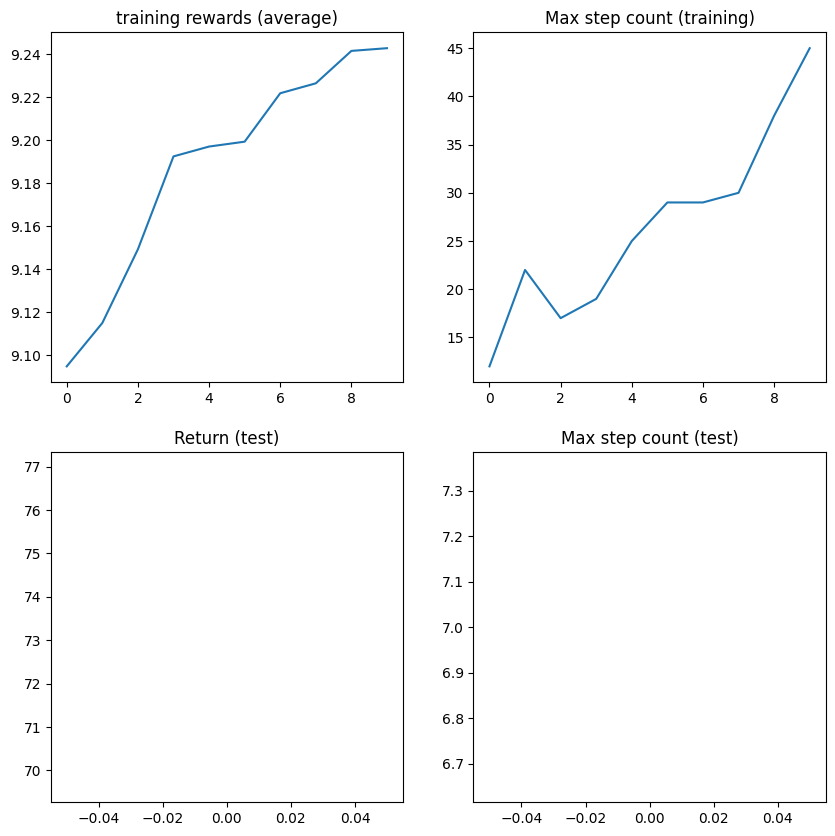

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()